# Experiments on NME

The following code accompanies paper X. It uses the ReSurfEMG library version v0.0.4. The code in this notebook generates dummy data as an example. Real data in the form of .poly5 files can be loaded in neuromuscular_efficiency_3lead_binder.ipynb.

Importing libraries:

In [11]:
import copy
import math
import collections
from scipy import interpolate as interp
from scipy import signal
import scipy
import pandas as pd
import glob
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

import neurokit2 as nk

import resurfemg
import resurfemg.helper_functions as hf

%matplotlib widget

In [3]:
# hf.(fg)

In [35]:
# Output data - General path to dir for saving .csvs and plots
main_output_dir = '../not_pushed/Output_data/'
if not os.path.exists(main_output_dir):
    os.makedirs(main_output_dir)

N_measurement = 0

In [8]:
time_view = "Seconds"

In [40]:
# do not rerun this cell
big_data_list= []

# Reruns for comparing measurements should be done from this cell as the start

Now you can set the parameters of the generated dummy data: timing settings, ventilator settings and patient variables.

For example: The script can be used for comparing neuro-muscular efficiency at different PEEP levels. To make such a comparison the peep (ventilator setting) and p_mus_max (patient variable) need to be adapted between runs

In [37]:
# Output data path - Patient specific
patient = "HOSP001"
N_measurement += 1
measurement = (3-len(str(N_measurement)))*'0' + str(N_measurement)

patient, measurement

('HOSP001', '002')

In [13]:
t_start = 0     # s
t_end = 7*60    # s
emg_sample_rate = 2048   # Hz
draeger_sample_rate = 100   # Hz 

# Ventilator settings:
peep = 10       # Positive end-expiratory pressure (cmH2O)
dp = 5          # Driving pressure (cmH2O)
rr = 22         # Respiratory rate /min
ie_ratio = 1/2  # Ratio between inspiratory and expiratory phase
ie_fraction = ie_ratio/(ie_ratio + 1)

# Patient variables
p_mus_max = 5   # Muscular pressure (cmH2O)
c = .050        # Respiratory system compliance (L/cmH2O)
r = 5           # Respiratory system resistance (cmH2O/L/s)
p_ip = -5       # Static interpleural pressure (cmH2O)

tau_mus_up = 0.3
tau_mus_down = 0.3

# To simulate occlussion measurements
# t_occs = np.array([])
t_occs = np.array([6*60+5, 6*60+21, 6*60+35])
t_occs = np.floor(t_occs*rr/60)*60/rr
for i, t_occ in enumerate(t_occs):
    if t_end < (t_occ + 60/rr):
        print('t=' +  str(t_occ) + ': t_occ should be at least a full respiratory cycle from t_end\n')

In [14]:
# Ventilator data generator

y_draeger = np.array([i/draeger_sample_rate for i in range(int(t_start*draeger_sample_rate), int(t_end*draeger_sample_rate))]) # Time axis

# Reference signal/Pattern generator
p_mus_block = (signal.square(y_draeger*rr/60*2*np.pi + 0.1, ie_fraction)+1)/2   
for i, t_occ in enumerate(t_occs):
    n_occ = int(t_occ*draeger_sample_rate)    
    p_mus_block[n_occ:n_occ+int(draeger_sample_rate*60/rr)+1] = np.zeros((int(draeger_sample_rate*60/rr)+1,))   # Add occlusion manouevres

# Simulate up- and downslope dynamics of respiratory muscle pressure
pattern_gen_mus = np.zeros((len(y_draeger),))
for i in range(1, len(y_draeger)):
    if (p_mus_block[i-1]-pattern_gen_mus[i-1]) > 0:
        pattern_gen_mus[i] = pattern_gen_mus[i-1]+(p_mus_block[i-1]-pattern_gen_mus[i-1])/(tau_mus_up*draeger_sample_rate)
    else:
        pattern_gen_mus[i] = pattern_gen_mus[i-1]+(p_mus_block[i-1]-pattern_gen_mus[i-1])/(tau_mus_down*draeger_sample_rate)

p_mus = p_mus_max * pattern_gen_mus

# Simulate up- and downslope dynamics of airway pressure
p_block = dp * (signal.square(y_draeger*rr/60*2*np.pi, ie_fraction)+1)/2
tau_dp_up = 10
tau_dp_down = 5
p_dp = -p_mus
for i in range(1, len(y_draeger)):
    if np.any((((t_occs*draeger_sample_rate)-i)<=0) &  ((((t_occs+60/rr)*draeger_sample_rate+1)-i)>0)):
        # Occlusion pressure results into negative airway pressure:
        p_dp[i] = p_dp[i-1]+(-p_block[i-1]-p_dp[i-1])/tau_dp_up
    elif (p_block[i-1]-p_dp[i-1]) > 0:
        p_dp[i] = p_dp[i-1]+(p_block[i-1]-p_dp[i-1])/tau_dp_up
    else:
        p_dp[i] = p_dp[i-1]+(p_block[i-1]-p_dp[i-1])/tau_dp_down

p_vent = peep + p_dp

# Calculate flows and volumes from equation of motion:
v_dot_vent = np.zeros((len(y_draeger),))
v_vent = np.zeros((len(y_draeger),))
for i in range(len(y_draeger)-1):
    if np.any((((t_occs*draeger_sample_rate)-i)<=0) &  ((((t_occs+60/rr)*draeger_sample_rate+1)-i)>0)):
        # During occlusion manoeuvre: flow and volume are zero
        v_dot_vent[i+1] = 0
        v_vent[i+1] = 0
    else:
        v_dot_vent[i+1] = ((p_dp[i] + p_mus[i]) - v_vent[i] / c)/r
        v_vent[i+1] = v_vent[i] + v_dot_vent[i+1] * 1/draeger_sample_rate

x_draeger = np.vstack((p_vent, v_dot_vent, v_vent))
data_draeger_samples = x_draeger



In [15]:
# EMG generator

y_emg = np.array([i/emg_sample_rate for i in range(int(t_start*emg_sample_rate), int(t_end*emg_sample_rate))]) # Time axis

# Reference signal/Pattern generator
emg_block = (signal.square(y_emg*rr/60*2*np.pi + 0.5, ie_fraction)+1)/2
for i, t_occ in enumerate(t_occs):
     n_occ = int(t_occ*emg_sample_rate)
     emg_block[n_occ:n_occ+int(emg_sample_rate*60/rr)+1] = (signal.square(np.arange(int(emg_sample_rate*60/rr)+1)/emg_sample_rate*rr/60*2*np.pi, ie_fraction)+1)/2

# Simulate up- and downslope dynamics of EMG
pattern_gen_emg = np.zeros((len(y_emg),))
for i in range(1, len(y_emg)):
    if (emg_block[i-1]-pattern_gen_emg[i-1]) > 0:
        pattern_gen_emg[i] = pattern_gen_emg[i-1]+(emg_block[i-1]-pattern_gen_emg[i-1])/(tau_mus_up*emg_sample_rate)
    else:
        pattern_gen_emg[i] = pattern_gen_emg[i-1]+(emg_block[i-1]-pattern_gen_emg[i-1])/(tau_mus_down*emg_sample_rate)


# ECG component
t_ecg = (t_end - t_start)
ecg_sample_rate = emg_sample_rate
part_ecg = nk.ecg_simulate(duration=t_ecg, sampling_rate=int(ecg_sample_rate*1.5), heart_rate=80/1.5) 
    # NB The simulated ECG is condensed, such that it results into more physiological QRS complex widths
part_ecg = part_ecg[:len(y_emg)]

# Respiratory EMG component
rng = np.random.default_rng(seed=42)
part_emg = pattern_gen_emg * np.random.normal(0, 0.5, size=(len(y_emg), ))

# Noise and drift componentss
part_noise = np.random.normal(0, 0.5, size=(len(y_emg), ))
part_drift = np.zeros((len(y_emg),))
b, a  = scipy.signal.butter(4, 0.1, btype='low', analog=False, output='ba', fs=emg_sample_rate)
# part_drift = scipy.signal.filtfilt(b, a, np.random.normal(0, 0.5, size=(len(y_emg), )))

# Mix channels
x_emg = np.zeros((3,len(y_emg)))
x_emg[0, :] = 200*part_ecg + 0.05 * part_emg + 1 * part_noise + 20 * part_drift
x_emg[1, :] = 200*part_ecg + 4 * part_emg + 1 * part_noise + 20 * part_drift
x_emg[2, :] = 200*part_ecg + 8 * part_emg + 1 * part_noise + 20 * part_drift

data_emg_samples = x_emg


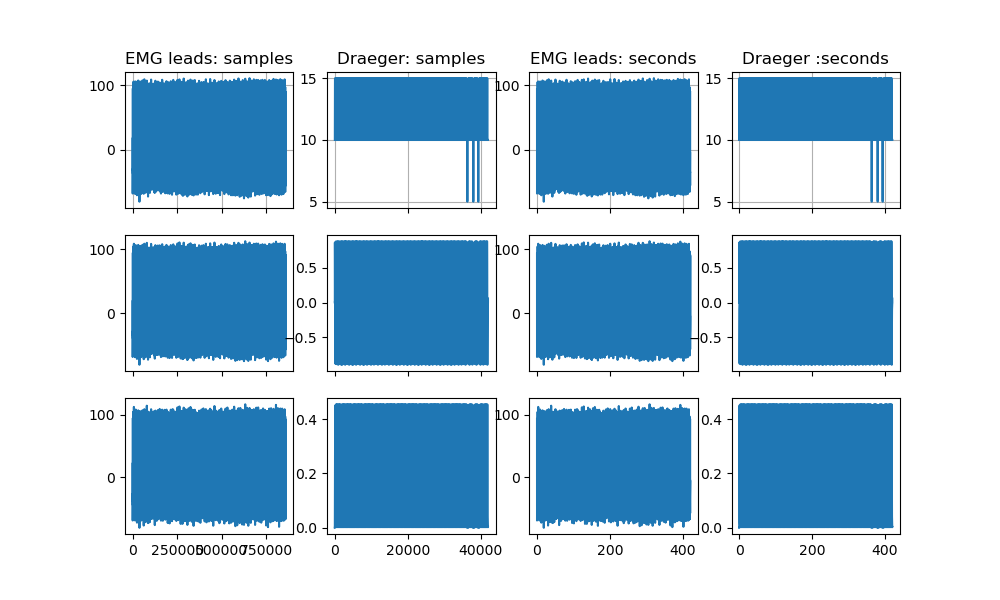

In [16]:
# Plot generated data
fig, axis = plt.subplots(nrows=3, ncols=4, figsize=(10, 6), sharex='col')
axis[0, 0].grid(True)
axis[0, 0].plot(x_emg[0])
axis[0, 0].set(title='EMG leads: samples')
axis[1, 0].plot(x_emg[1])
axis[2, 0].plot(x_emg[2])

axis[0, 1].set(title='Draeger: samples')
axis[0, 1].grid(True)
axis[0, 1].plot(x_draeger[0])
axis[1, 1].plot(x_draeger[1])
axis[2, 1].plot(x_draeger[2])

axis[0, 2].grid(True)
axis[0, 2].plot(y_emg, x_emg[0])
axis[0, 2].set(title='EMG leads: seconds')
axis[1, 2].plot(y_emg, x_emg[1])
axis[2, 2].plot(y_emg, x_emg[2])

axis[0, 3].set(title='Draeger :seconds')
axis[0, 3].grid(True)
axis[0, 3].plot(y_draeger, x_draeger[0])
axis[1, 3].plot(y_draeger, x_draeger[1])
axis[2, 3].plot(y_draeger, x_draeger[2])

Here select the time window in seconds (start through stop time) where the occlusion start and stop with a few seconds (~ a breath) margin. 
It is advised to never start at zero, or end after the signal, and the widgets have been constrained to do this.

In [25]:
start_widget = widgets.BoundedFloatText(
    value=np.floor(y_draeger[-1]-60),
    min=1,
    max=y_draeger[-1],
    step=1,
    description='Start:',
    disabled=False
)
end_widget = widgets.BoundedFloatText(
    value=np.floor(y_draeger[-1]-10),
    min=1,
    max=y_draeger[-1],
    step=1,
    description='End:',
    disabled=False
)
widgets.VBox([start_widget, end_widget])

In [18]:
start = start_widget.value
end = end_widget.value
if start >= end:
    print('Please choose logical values. You made a mistake.')

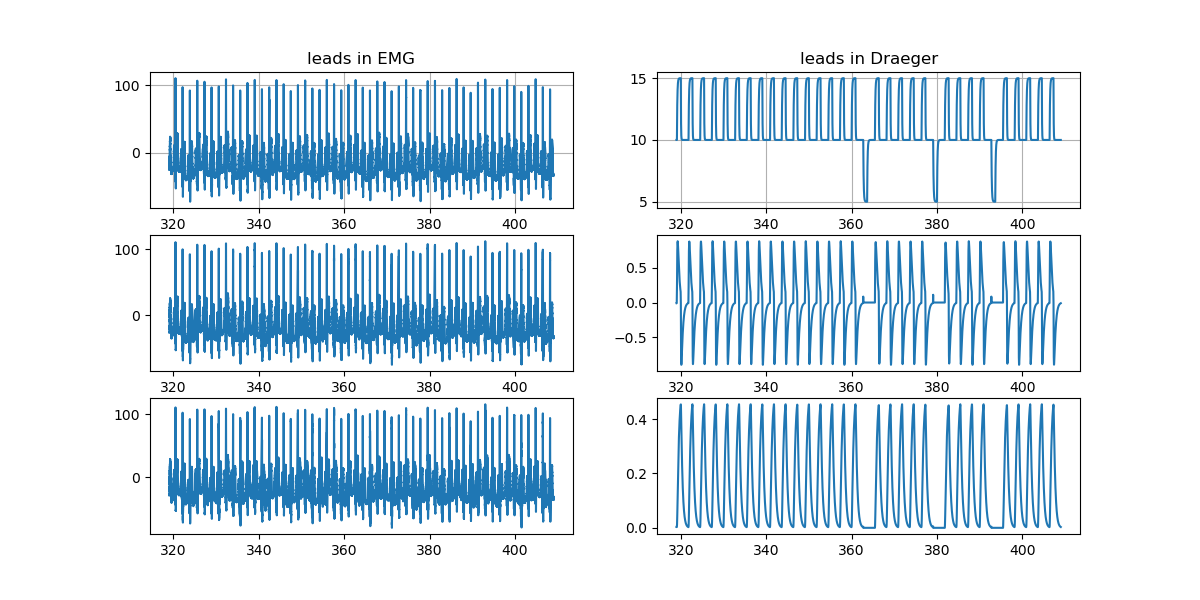

In [19]:
# now examine at the selected window to contain all occlusions

start_s = int(float(start)* emg_sample_rate)
end_s = min([int(float(end)*emg_sample_rate), len(x_emg[0,:])-1])
start_draeger_s = int(float(start)* draeger_sample_rate)
end_draeger_s = min([int(float(end)* draeger_sample_rate), len(x_draeger[0,:])-1])

fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(12, 6))
axis[0, 0].set(title='leads in EMG')
axis[0, 0].grid(True)
axis[0, 0].plot(y_emg[int(start_s):int(end_s)], x_emg[0][int(start_s):int(end_s)])
axis[1, 0].plot(y_emg[int(start_s):int(end_s)], x_emg[1][int(start_s):int(end_s)])
axis[2, 0].plot(y_emg[int(start_s):int(end_s)], x_emg[2][int(start_s):int(end_s)])

axis[0, 1].set(title='leads in Draeger')
axis[0, 1].grid(True)
axis[0, 1].plot(
    y_draeger[int(start_draeger_s):int(end_draeger_s)], 
    x_draeger[0][int(start_draeger_s):int(end_draeger_s)]
)
axis[1, 1].plot(
    y_draeger[int(start_draeger_s):int(end_draeger_s)], 
    x_draeger[1][int(start_draeger_s):int(end_draeger_s)]
)
axis[2, 1].plot(
    y_draeger[int(start_draeger_s):int(end_draeger_s)], 
    x_draeger[2][int(start_draeger_s):int(end_draeger_s)]
)

Happy with your selection? If not redo

# Pre-processing pipeline

In [20]:
# Eliminate the baseline wander from the data
bd_filtered_file_data = hf.emg_bandpass_butter_sample(x_emg, 1, 500, 2048, output='sos')
    
processed_data_emg_di = bd_filtered_file_data[1]
processed_data_emg_para = bd_filtered_file_data[2]

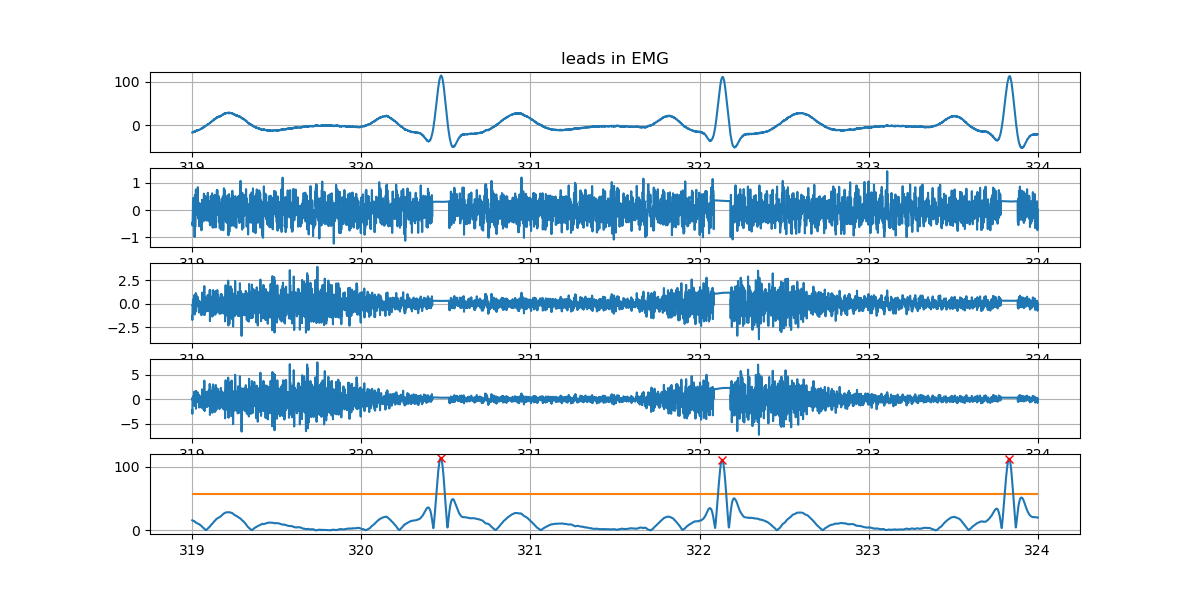

In [21]:
# Apply QRS gating
# Gating settings
plot_window = 5         # Window size to plot the gating results from
peak_fraction = 0.50    # Peak height fraction
ECG_shift = -0           # Shift of gated in samples relative to detected peaks
gate_width = 0.1        # Gate width in seconds

# Detect ECG peaks on 1Hz high-pass filtered signals
peak_width = 0.001
peak_dist = int(emg_sample_rate/3)

ecg = bd_filtered_file_data[0]
ecg_rms = hf.full_rolling_rms(ecg, 10)
max_ecg_rms = max(ecg_rms[int(start_s):int(start_s+plot_window*emg_sample_rate)])
min_ecg_rms = min(ecg_rms[int(start_s):int(start_s+plot_window*emg_sample_rate)])
peak_height = peak_fraction*(max_ecg_rms - min_ecg_rms)

ECG_peaks, properties  = scipy.signal.find_peaks(
    ecg_rms, 
    height=peak_height, 
    width=peak_width*emg_sample_rate, 
    distance=peak_dist
)
ECG_peaks = ECG_peaks - ECG_shift

# Filter EXG signals 20Hz high pass
ECG_h20 = hf.emg_bandpass_butter_sample(ecg, 20, 500, 2048, output='sos')
emg_di_h20 = hf.emg_bandpass_butter_sample(processed_data_emg_di, 20, 500, 2048, output='sos')
emg_para_h20 = hf.emg_bandpass_butter_sample(processed_data_emg_para, 20, 500, 2048, output='sos')

# Gate ECG and EMG signal
gate_fill_method = 3    # 0: Zeros, 1: Interpolate start-end, 2: Average prior data, 3: Moving average
gate_width_samples = int(gate_width*emg_sample_rate)

gate_samples = list()
for i in range(len(ECG_peaks)):
    for k in range(int(ECG_peaks[i]-gate_width_samples/2),int(ECG_peaks[i]+gate_width_samples/2)):
        gate_samples.append(k)

ECG_gated = hf.gating(ECG_h20, ECG_peaks, gate_width=gate_width_samples, method=3)
emg_di_gated = hf.gating(emg_di_h20, ECG_peaks, gate_width=gate_width_samples, method=3)
emg_para_gated = hf.gating(emg_para_h20, ECG_peaks, gate_width=gate_width_samples, method=3)

# Plot output data --------------------------------

fig, axis = plt.subplots(nrows=5, ncols=1, figsize=(12, 6))
start_i = int(start_s)
end_i = int(start_s+plot_window*2048)
axis[0].grid(True)
axis[0].plot(y_emg[start_i:end_i], bd_filtered_file_data[0, start_i:end_i])

axis[0].set(title='leads in EMG')
axis[1].grid(True)
axis[1].plot(y_emg[start_i:end_i], ECG_gated[start_i:end_i])
axis[2].grid(True)
axis[2].plot(y_emg[start_i:end_i], emg_di_gated[start_i:end_i])
axis[3].grid(True)
axis[3].plot(y_emg[start_i:end_i], emg_para_gated[start_i:end_i])

axis[4].grid(True)
axis[4].plot(y_emg[start_i:end_i], ecg_rms[start_i:end_i])
axis[4].hlines(
    y=peak_height, 
    xmin=y_emg[start_i], 
    xmax=y_emg[end_i],
    color = "C1"
)

for idx in range(len(ECG_peaks)):
    if (ECG_peaks[idx] > int(start_s)) & (ECG_peaks[idx] < int(start_s+plot_window*2048)):
        axis[4].plot(y_emg[ECG_peaks[idx]], ecg_rms[ECG_peaks[idx]],'rx')


# Calculate root mean squared signal (RMS)

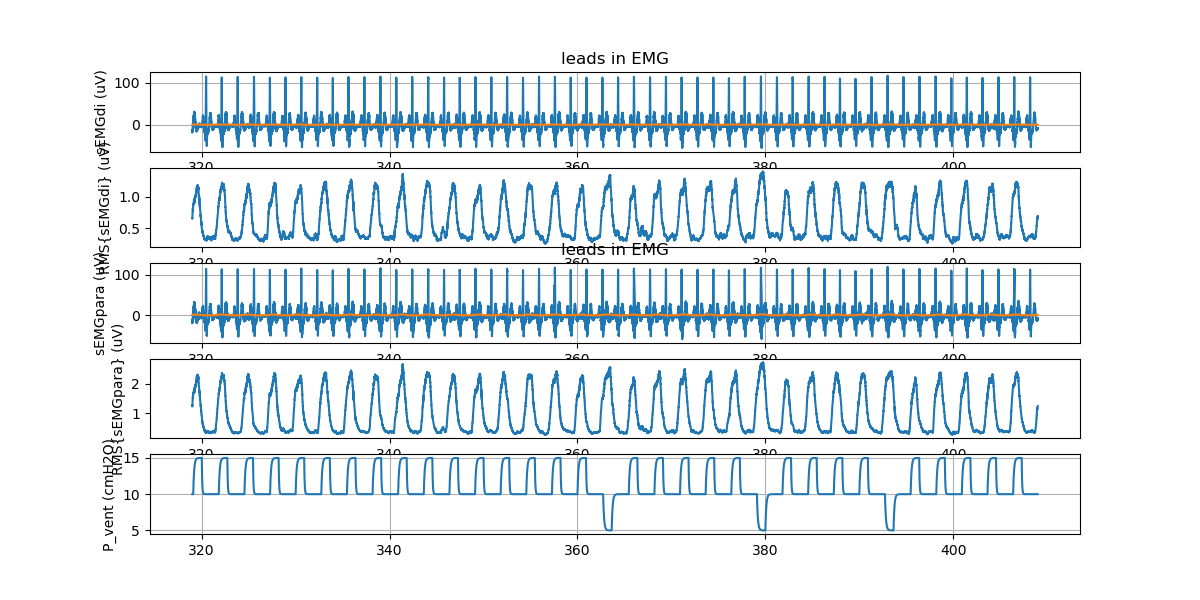

In [22]:
RMS_window_ms = 200
RMS_windows_samp = int(RMS_window_ms / 1000 *  emg_sample_rate)

RMS_data_emg_di = hf.full_rolling_rms(emg_di_gated, RMS_windows_samp)
RMS_data_emg_para = hf.full_rolling_rms(emg_para_gated, RMS_windows_samp)

fig, axis = plt.subplots(nrows=5, ncols=1, figsize=(12, 6))
axis[0].set(title='leads in EMG')
axis[0].set_ylabel('sEMGdi (uV)')
axis[0].grid(True)
axis[0].plot(y_emg[int(start_s):int(end_s)], processed_data_emg_di[int(start_s):int(end_s)])
axis[0].plot(y_emg[int(start_s):int(end_s)], RMS_data_emg_di[int(start_s):int(end_s)])

axis[1].set_xlabel('t (s)')
axis[1].set_ylabel('RMS{sEMGdi} (uV)')
axis[1].plot(y_emg[int(start_s):int(end_s)], RMS_data_emg_di[int(start_s):int(end_s)])

axis[2].set(title='leads in EMG')
axis[2].set_ylabel('sEMGpara (uV)')
axis[2].grid(True)
axis[2].plot(y_emg[int(start_s):int(end_s)], processed_data_emg_para[int(start_s):int(end_s)])
axis[2].plot(y_emg[int(start_s):int(end_s)], RMS_data_emg_para[int(start_s):int(end_s)])

axis[3].set_xlabel('t (s)')
axis[3].set_ylabel('RMS{sEMGpara} (uV)')
axis[3].plot(y_emg[int(start_s):int(end_s)], RMS_data_emg_para[int(start_s):int(end_s)])

axis[4].set_ylabel('P_vent (cmH2O)')
axis[4].grid(True)
axis[4].plot(
    y_draeger[int(start_draeger_s):int(end_draeger_s)], 
    x_draeger[0][int(start_draeger_s):int(end_draeger_s)]
)



Determine PEEP level

In [23]:
x = x_draeger[2][:int(start_draeger_s)]
V_ee_PKS, _ = scipy.signal.find_peaks(-x)

PEEP_set = np.floor(np.median(x_draeger[0, V_ee_PKS]))


PEEP_set

10.0

Get PTPocc

In [24]:
# Moving baseline on pressure and all EMG signals for baseline crossing detection

baseline_W_emg = 5 * emg_sample_rate  # window length
baseline_W_draeger = 5 * draeger_sample_rate  # window length

# emg_di_rolling_base_line = np.percentile(strided_app(RMS_data_emg[int(start_s):int(end_s)], W,1), 33, axis=-1)
emg_di_rolling_base_line = np.zeros(
    (len(RMS_data_emg_di[int(start_s):int(end_s)]), ))
emg_para_rolling_base_line = np.zeros(
    (len(RMS_data_emg_para[int(start_s):int(end_s)]), ))
P_rolling_base_line = np.zeros(
    (len(x_draeger[0, int(start_draeger_s):int(end_draeger_s)]), ))

for idx in range(int(end_s)-int(start_s)):
    start_i = max([int(start_s), int(start_s)+idx-int(baseline_W_emg/2)])
    end_i = min([int(end_s), int(start_s)+idx+int(baseline_W_emg/2)])
    emg_di_rolling_base_line[idx] = np.percentile(
        RMS_data_emg_di[start_i:end_i], 33)
    emg_para_rolling_base_line[idx] = np.percentile(
        RMS_data_emg_para[start_i:end_i], 33)

for idx in range(int(end_draeger_s)-int(start_draeger_s)):
    start_i = max([int(start_draeger_s), int(
        start_draeger_s)+idx-int(baseline_W_draeger/2)])
    end_i = min([int(end_draeger_s), int(start_draeger_s) +
                idx+int(baseline_W_draeger/2)])
    P_rolling_base_line[idx] = np.percentile(x_draeger[0, start_i:end_i], 33)

In [26]:
# Detect (negative) occlussion peaks in pressure signal
Pocc_prominence_factor = 0.3

treshold = 0
width = int(0.1 * draeger_sample_rate)
prominence = Pocc_prominence_factor *np.abs( PEEP_set - min(x_draeger[0]))
height = -(PEEP_set - Pocc_prominence_factor *np.abs( PEEP_set - min(x_draeger[0])))
distance = int(0.5 * draeger_sample_rate)

x = x_draeger[0, int(start_draeger_s):int(end_draeger_s)]
P_occ_peaks, properties  = scipy.signal.find_peaks(
    -x, 
    height=height, 
    prominence=prominence, 
    width=width, 
    distance=distance
)
# x = x_draeger[0, int(start_draeger_s):int(end_draeger_s)]

PEEP_crossings_idx = np.argwhere(np.diff(np.sign(x - P_rolling_base_line)) != 0)

P_occ_starts = np.zeros((len(P_occ_peaks),), dtype=int)
P_occ_ends = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    PEEP_crossings_idx_sub = np.sign(x[:P_occ_peaks[idx]] - P_rolling_base_line[:P_occ_peaks[idx]])
    a = np.argmin(P_occ_peaks[idx] - np.argwhere(np.diff(PEEP_crossings_idx_sub) != 0))
    P_occ_starts[idx] = int(PEEP_crossings_idx[a])
    P_occ_ends[idx] = int(PEEP_crossings_idx[a+1])

P_occ_starts,P_occ_peaks,  P_occ_ends, prominence, height

(array([4373, 6010, 7373]),
 array([4464, 6100, 7464], dtype=int64),
 array([4538, 6175, 7538]),
 1.499897160580138,
 -8.500102839419862)

In [27]:
# Data sanity check

In [28]:
#check to make sure your data has an occlusion even
if len(P_occ_starts) == 0 or len(P_occ_peaks) ==0  or len(P_occ_ends) == 0:
    print('You have chosen something without the proper sort of occlusion peak, please examine data')
else:
    print('You may continue!')

You may continue!


EMG peak identification

In [29]:
# EMG peak detection parameters:
EMG_di_prominence_factor = 0.15         # Threshold peak height as fraction of max peak height 
EMG_para_prominence_factor = 0.15       # Threshold peak height as fraction of max peak height

In [30]:
# Find diaphragmatic EMG peaks

y_di = RMS_data_emg_di[int(start_s):int(end_s)]
treshold = 0
width = int(0.1 * emg_sample_rate)
prominence = EMG_di_prominence_factor * \
    (max(y_di)-np.percentile(y_di[:-emg_sample_rate], 5))
EMG_peaks_di, properties = scipy.signal.find_peaks(
    y_di, height=treshold, prominence=prominence, width=width)

draeger_delay = 0.5

# Link EMG peak closest to occlusion pressures
EMG_di_occ_peaks = np.zeros((len(P_occ_peaks),), dtype=int)
PKS_idx = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    P_occ_peak_converted = P_occ_peaks[idx]/draeger_sample_rate*emg_sample_rate
    PKS_idx[idx] = np.argmin(
        np.abs(EMG_peaks_di + draeger_delay * emg_sample_rate - P_occ_peak_converted))

    EMG_di_occ_peaks[idx] = EMG_peaks_di[PKS_idx[idx]]

baseline_crossings_idx = np.argwhere(
    np.diff(np.sign(y_di - emg_di_rolling_base_line)) != 0)

EMG_di_occ_starts = np.zeros((len(P_occ_peaks),), dtype=int)
EMG_di_occ_ends = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    baseline_crossings_idx_sub = np.sign(
        y_di[:EMG_di_occ_peaks[idx]] - emg_di_rolling_base_line[:EMG_di_occ_peaks[idx]])
    a = np.argmin(
        EMG_di_occ_peaks[idx] - np.argwhere(np.diff(baseline_crossings_idx_sub) != 0))
    EMG_di_occ_starts[idx] = int(baseline_crossings_idx[a])
    EMG_di_occ_ends[idx] = int(baseline_crossings_idx[a+1])

EMG_di_occ_starts, EMG_di_occ_peaks, EMG_di_occ_ends

(array([ 88877, 122369, 150383]),
 array([ 91116, 124435, 152097]),
 array([ 92988, 125780, 153989]))

In [31]:
# Find parasternal EMG peaks

y_para = RMS_data_emg_para[int(start_s):int(end_s)]
treshold = 0
width = int(0.1 * emg_sample_rate)
prominence = EMG_para_prominence_factor * \
    (max(y_para)-np.percentile(y_para[:-emg_sample_rate], 5))
EMG_peaks_para, properties = scipy.signal.find_peaks(
    y_para, height=treshold, prominence=prominence, width=width)

draeger_delay = 0.5

# Link EMG peak closest to occlusion pressures
EMG_para_occ_peaks = np.zeros((len(P_occ_peaks),), dtype=int)
PKS_idx = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    P_occ_peak_converted = P_occ_peaks[idx]/draeger_sample_rate*emg_sample_rate
    PKS_idx[idx] = np.argmin(
        np.abs(EMG_peaks_para + draeger_delay * emg_sample_rate - P_occ_peak_converted))
    EMG_para_occ_peaks[idx] = EMG_peaks_para[PKS_idx[idx]]

baseline_crossings_idx = np.argwhere(
    np.diff(np.sign(y_para - emg_para_rolling_base_line)) != 0)

EMG_para_occ_starts = np.zeros((len(P_occ_peaks),), dtype=int)
EMG_para_occ_ends = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    baseline_crossings_idx_sub = np.sign(
        y_para[:EMG_para_occ_peaks[idx]] - emg_para_rolling_base_line[:EMG_para_occ_peaks[idx]])
    a = np.argmin(
        EMG_para_occ_peaks[idx] - np.argwhere(np.diff(baseline_crossings_idx_sub) != 0))
    EMG_para_occ_starts[idx] = int(baseline_crossings_idx[a])
    EMG_para_occ_ends[idx] = int(baseline_crossings_idx[a+1])

EMG_para_occ_starts, EMG_para_occ_peaks, EMG_para_occ_ends

(array([ 88866, 122350, 150333]),
 array([ 91116, 124434, 152414]),
 array([ 92805, 126119, 154119]))

Text(0.5, 0, 't (s)')

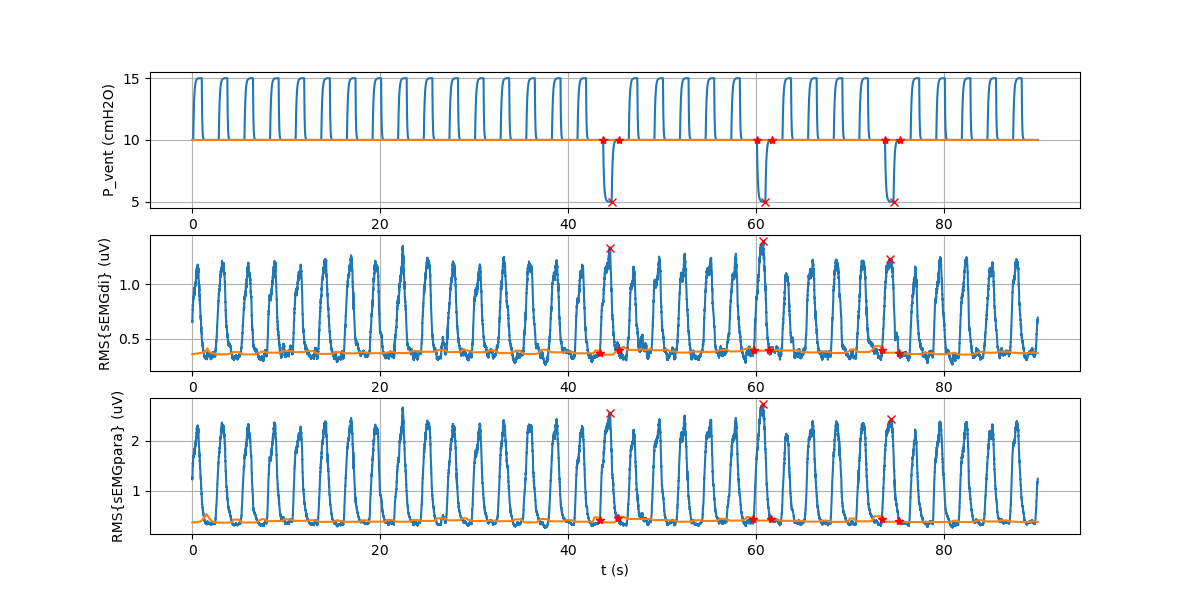

In [32]:
# Plot entire selected time window with indicated peaks

fig_1, axis = plt.subplots(nrows=3, ncols=1, figsize=(12, 6))
axis[0].grid(True)
axis[0].plot([y / draeger_sample_rate for y in range(len(x))], x)
axis[0].plot([y / draeger_sample_rate for y in range(len(x))],
             P_rolling_base_line)
axis[0].plot(P_occ_peaks/draeger_sample_rate, x[P_occ_peaks], "x", color="r")
axis[0].plot(P_occ_starts / draeger_sample_rate,
             P_rolling_base_line[P_occ_starts], '*r')
axis[0].plot(P_occ_ends / draeger_sample_rate,
             P_rolling_base_line[P_occ_ends], '*r')
axis[0].set_ylabel('P_vent (cmH2O)')

# Rolling baseline:
axis[1].grid(True)
N_samp = len(RMS_data_emg_di[int(start_s):int(end_s)])
axis[1].plot([y / emg_sample_rate for y in range(N_samp)],
             RMS_data_emg_di[int(start_s):int(end_s)])
axis[1].plot([y / emg_sample_rate for y in range(N_samp)],
             emg_di_rolling_base_line[:int(end_s)-int(start_s)])
axis[1].plot(EMG_di_occ_peaks/emg_sample_rate,
             y_di[EMG_di_occ_peaks], "x", color="r")
axis[1].plot(EMG_di_occ_starts / emg_sample_rate,
             emg_di_rolling_base_line[EMG_di_occ_starts], '*r')
axis[1].plot(EMG_di_occ_ends / emg_sample_rate,
             emg_di_rolling_base_line[EMG_di_occ_ends], '*r')
axis[1].set_ylabel('RMS{sEMGdi} (uV)')
axis[1].set_xlabel('t (s)')
# axis[1].set_ylim([0, 15])


axis[2].grid(True)
axis[2].plot([y / emg_sample_rate for y in range(N_samp)],
             RMS_data_emg_para[int(start_s):int(end_s)])
axis[2].plot(EMG_para_occ_peaks/emg_sample_rate,
             y_para[EMG_para_occ_peaks], "x", color="r")

# Rolling baseline:
axis[2].plot([y / emg_sample_rate for y in range(N_samp)],
             emg_para_rolling_base_line[:int(end_s)-int(start_s)])
axis[2].plot(EMG_para_occ_starts / emg_sample_rate,
             emg_para_rolling_base_line[EMG_para_occ_starts], '*r')
axis[2].plot(EMG_para_occ_ends / emg_sample_rate,
             emg_para_rolling_base_line[EMG_para_occ_ends], '*r')
axis[2].set_ylabel('RMS{sEMGpara} (uV)')
axis[2].set_xlabel('t (s)')
# axis[2].set_ylim([0, 15])

(array([4.54664063, 4.49697659, 4.54664063]),
 array([0.91717706, 0.90952741, 0.88630509]),
 array([2.22429332, 2.28880847, 2.15723395]),
 array([4.95721147, 4.94430024, 5.1298821 ]))

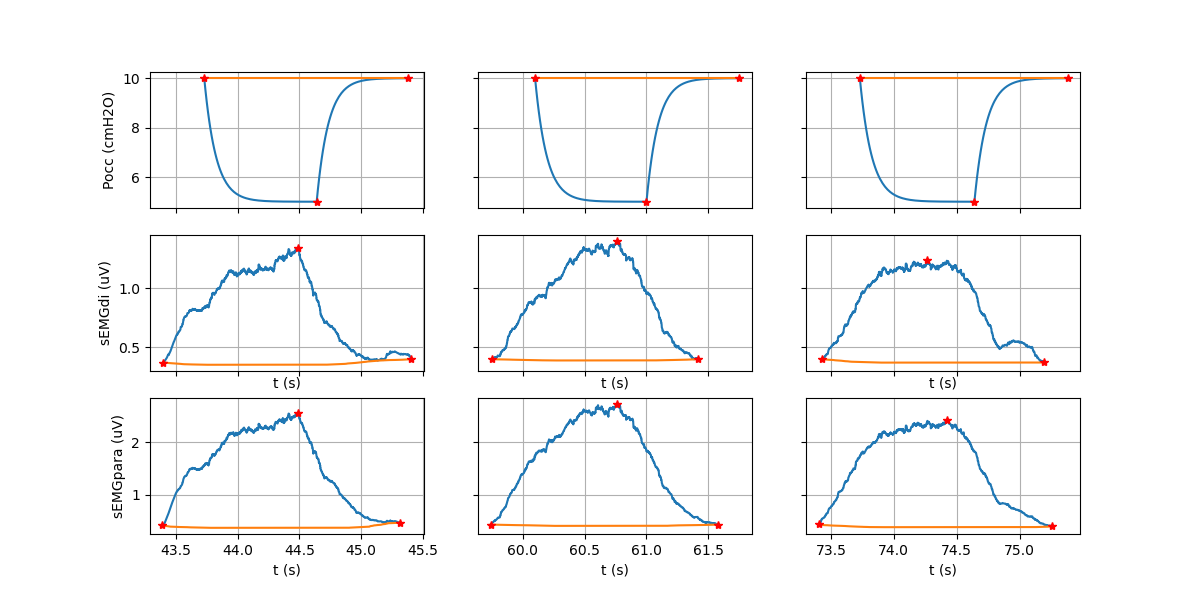

In [33]:
# Subplot per indicated peak
fig_2, axis = plt.subplots(nrows=3, ncols=len(
    P_occ_peaks), figsize=(12, 6), sharex='col', sharey='row')


PTP_occs = np.zeros((len(P_occ_peaks),))
for idx in range(len(P_occ_peaks)):
    start_i = P_occ_starts[idx]
    end_i = P_occ_ends[idx]
    axis[0, idx].grid(True)
    axis[0, idx].plot(y_draeger[start_i:end_i+1], x[start_i:end_i+1])
    axis[0, idx].plot(y_draeger[start_i:end_i+1],
                      P_rolling_base_line[start_i:end_i+1])

    axis[0, idx].plot(y_draeger[P_occ_peaks[idx]], x[P_occ_peaks[idx]], '*r')
    axis[0, idx].plot(y_draeger[start_i], x[start_i], '*r')
    axis[0, idx].plot(y_draeger[end_i], x[end_i], '*r')

    # Pressure Time Product (ETP) occlusion
    PTP_occs[idx] = np.abs(np.trapz(
        x[start_i:end_i+1]-P_rolling_base_line[start_i:end_i+1],
        dx=1/draeger_sample_rate
    ))

axis[0, 0].set_ylabel('Pocc (cmH2O)')

ETP_di_occs = np.zeros((len(EMG_di_occ_peaks),))
for idx in range(len(EMG_di_occ_peaks)):
    start_i = EMG_di_occ_starts[idx]
    end_i = EMG_di_occ_ends[idx]

    axis[1, idx].grid(True)
    axis[1, idx].plot(y_emg[start_i:end_i+1], y_di[start_i:end_i+1])
    axis[1, idx].plot(y_emg[start_i:end_i+1],
                      emg_di_rolling_base_line[start_i:end_i+1])
    axis[1, idx].plot(y_emg[EMG_di_occ_peaks[idx]],
                      y_di[EMG_di_occ_peaks[idx]], '*r')
    axis[1, idx].plot(y_emg[start_i], y_di[start_i], '*r')
    axis[1, idx].plot(y_emg[end_i], y_di[end_i], '*r')

    # EMG Time Product (ETP) diaphragm
    ETP_di_occs[idx] = np.trapz(
        y_di[start_i:end_i+1] - emg_di_rolling_base_line[start_i:end_i+1],
        dx=1/emg_sample_rate
    )

    axis[1, idx].set_xlabel('t (s)')

axis[1, 0].set_ylabel('sEMGdi (uV)')

ETP_para_occs = np.zeros((len(EMG_para_occ_peaks),))
for idx in range(len(EMG_para_occ_peaks)):
    start_i = EMG_para_occ_starts[idx]
    end_i = EMG_para_occ_ends[idx]

    axis[2, idx].grid(True)
    axis[2, idx].plot(y_emg[start_i:end_i+1], y_para[start_i:end_i+1])
    axis[2, idx].plot(y_emg[start_i:end_i+1],
                      emg_para_rolling_base_line[start_i:end_i+1])
    axis[2, idx].plot(y_emg[EMG_para_occ_peaks[idx]],
                      y_para[EMG_para_occ_peaks[idx]], '*r')
    axis[2, idx].plot(y_emg[start_i], y_para[start_i], '*r')
    axis[2, idx].plot(y_emg[end_i], y_para[end_i], '*r')

    # EMG Time Product (ETP) parasternal
    ETP_para_occs[idx] = np.trapz(
        y_para[start_i:end_i+1] - emg_di_rolling_base_line[start_i:end_i+1],
        dx=1/emg_sample_rate
    )

    axis[2, idx].set_xlabel('t (s)')

axis[2, 0].set_ylabel('sEMGpara (uV)')


# Calculated neuromuscular efficiency: NME = PTP / ETP_di
NME_di = np.abs(PTP_occs)/ETP_di_occs

PTP_occs, ETP_di_occs, ETP_para_occs, NME_di

Store values for later analysis

In [41]:
if not os.path.exists(main_output_dir + patient + '/'):
    os.makedirs(main_output_dir + patient + '/')
    
fig_1.savefig(main_output_dir + patient + '/' + patient + '_' +
              measurement + '_timeplots_'+str(int(gate_width*1000))+'.png', dpi=300)
fig_2.savefig(main_output_dir + patient + '/' + patient + '_' +
              measurement + '_snapshots_'+str(int(gate_width*1000))+'.png', dpi=300)

for idx in range(len(PTP_occs)):
    data_now = [patient, measurement, PEEP_set, PTP_occs[idx],
                ETP_di_occs[idx], NME_di[idx], ETP_para_occs[idx]]
    big_data_list.append(data_now)


patient, measurement

('HOSP001', '002')

In [42]:
big_data_list

[['HOSP001',
  '002',
  10.0,
  4.546640632114057,
  0.9171770583161125,
  4.957211468482916,
  2.224293319234487],
 ['HOSP001',
  '002',
  10.0,
  4.496976591935926,
  0.9095274096906741,
  4.944300242106311,
  2.288808466103023],
 ['HOSP001',
  '002',
  10.0,
  4.546640632114057,
  0.8863050927479306,
  5.129882101904094,
  2.1572339512339873]]

In [43]:
columns_now = ['patient', 'measurement', 'PEEP_set', 'PTP_occs', 'ETP_di_occs', 'NME_di', 'ETP_para_occs'
               ]
df = pd.DataFrame(big_data_list, columns=columns_now)
df

,patient,measurement,PEEP_set,PTP_occs,ETP_di_occs,NME_di,ETP_para_occs
0,HOSP001,002,10.0,4.546641,0.917177,4.957211,2.224293
1,HOSP001,002,10.0,4.496977,0.909527,4.944300,2.288808
2,HOSP001,002,10.0,4.546641,0.886305,5.129882,2.157234


Text(0.5, 1.0, '')

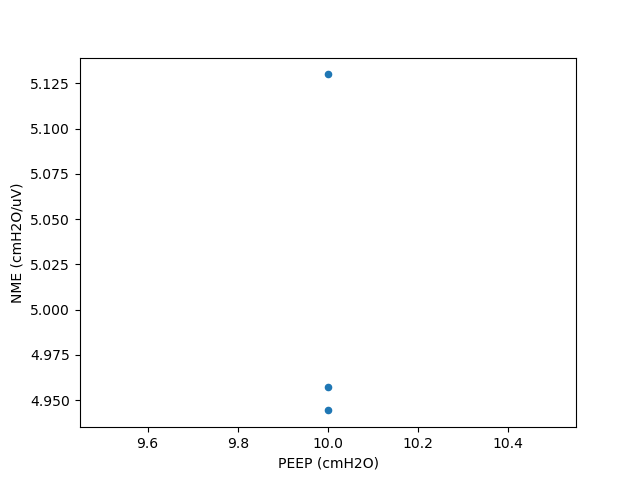

In [44]:
bp = df.plot.scatter('PEEP_set', 'NME_di')
bp.set_ylabel('NME (cmH2O/uV)')
bp.set_xlabel('PEEP (cmH2O)')
bp.set_title('')

In [45]:
df.to_csv(main_output_dir + patient + '/' + patient +
          '_my_saved_NME_experiments_gate_'+str(int(gate_width*1000))+'.csv')
# bp.figure.savefig(main_output_dir + patient + '/' + patient + '_'+str(int(gate_width*1000))+'_boxplot.png', dpi=300)
bp.figure.savefig(main_output_dir + patient + '/' + patient +
                  '_'+str(int(gate_width*1000))+'_scatter.png', dpi=300)